In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import uproot
import xgboost as xgb
import HomeMade as hm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import plot_tree

In [330]:
N = 2e5

all_features = "v0_ks_mass cosTheta trueKs".split(" ")

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(all_features, entrystop = N)

from scipy.special import logit
mc.cosTheta = ((mc.cosTheta+1-1e-15)/2).apply(lambda x: logit(x))

f = all_features[:-1]

# mc[f] = mc[f]@(1/np.sqrt(2)*np.array([[1,-1],[1,1]]))

train_test_slice = int(1e5)
train_mc = mc[:train_test_slice]
test_mc = mc[train_test_slice:]

In [336]:
cla_lda = LDA()
cla_dt = DT(max_depth=6)
cla_xgb = xgb.XGBClassifier(max_depth=6)

In [337]:
class cla_cuts():
    def predict(x):
#         return np.where((x[:,0] > 338.441)&(x[:,0]<454.445)&(x[:,1] > -364.6841), 1,0)
        return np.where((x[:,0] > 462.949)&(x[:,0]<532.403)&(x[:,1] > 4.7671), 1,0)
from scipy.optimize import minimize
class fisher():

    def predict(self,x):
        proj = x@self.w
        return np.where(proj<self.cut,1,0)
        
    def fit(self,x,y):
        self.w = np.linalg.inv(x[y==0].cov() + x[y==1].cov())@(x[y==0].mean(axis=0) - x[y==1].mean(axis=0))
        proj = x@self.w
        def gini(cut):
            if (proj<cut[0]).sum() != 0:
                p1 = (y[proj<cut[0]] == 1).sum()/(proj<cut[0]).sum()
            else:
                p1 = 0
            if (proj>=cut[0]).sum() != 0:
                p2 = (y[proj>=cut[0]] == 1).sum()/(proj>=cut[0]).sum()
            else:
                p2 = 0
#             print(cut[0],2*p1*(1-p1) + 2*p2*(1-p2))
            return -((proj<cut[0]).sum()*2*p1*(1-p1) + (proj>=cut[0]).sum()*2*p2*(1-p2))/len(proj)
        m = minimize(gini,[-2],options={'eps':0.005})
        self.cut = m.x
        
cla_fisher = fisher()
cla_fisher.fit(train_mc[f],train_mc.trueKs)
cla_lda.fit(train_mc[f],train_mc.trueKs)
cla_dt.fit(train_mc[f],train_mc.trueKs)
cla_xgb.fit(train_mc[f].to_numpy(),train_mc.trueKs)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [338]:
def grid_class(cla,ax,N_grid=500):
    d = len(f)
    mins = test_mc[f].min(axis=0)
    maxs = test_mc[f].max(axis=0)
    step_sizes = (maxs-mins)/N_grid
    string = "np.mgrid["
    for i in range(d):
        string += str(mins[i])+":"+str(maxs[i])+":"+str(step_sizes[i])+","
    string = string[:-1] + "]"

    grid = eval(string)
    temp = grid.reshape(d,-1).T
    
    classification = cla.predict(temp)
    classification = classification.reshape(grid.shape[1:])
    
    ax.contourf(grid[1],grid[0],classification,cmap=matplotlib.colors.ListedColormap(['red','green']),alpha=0.2)

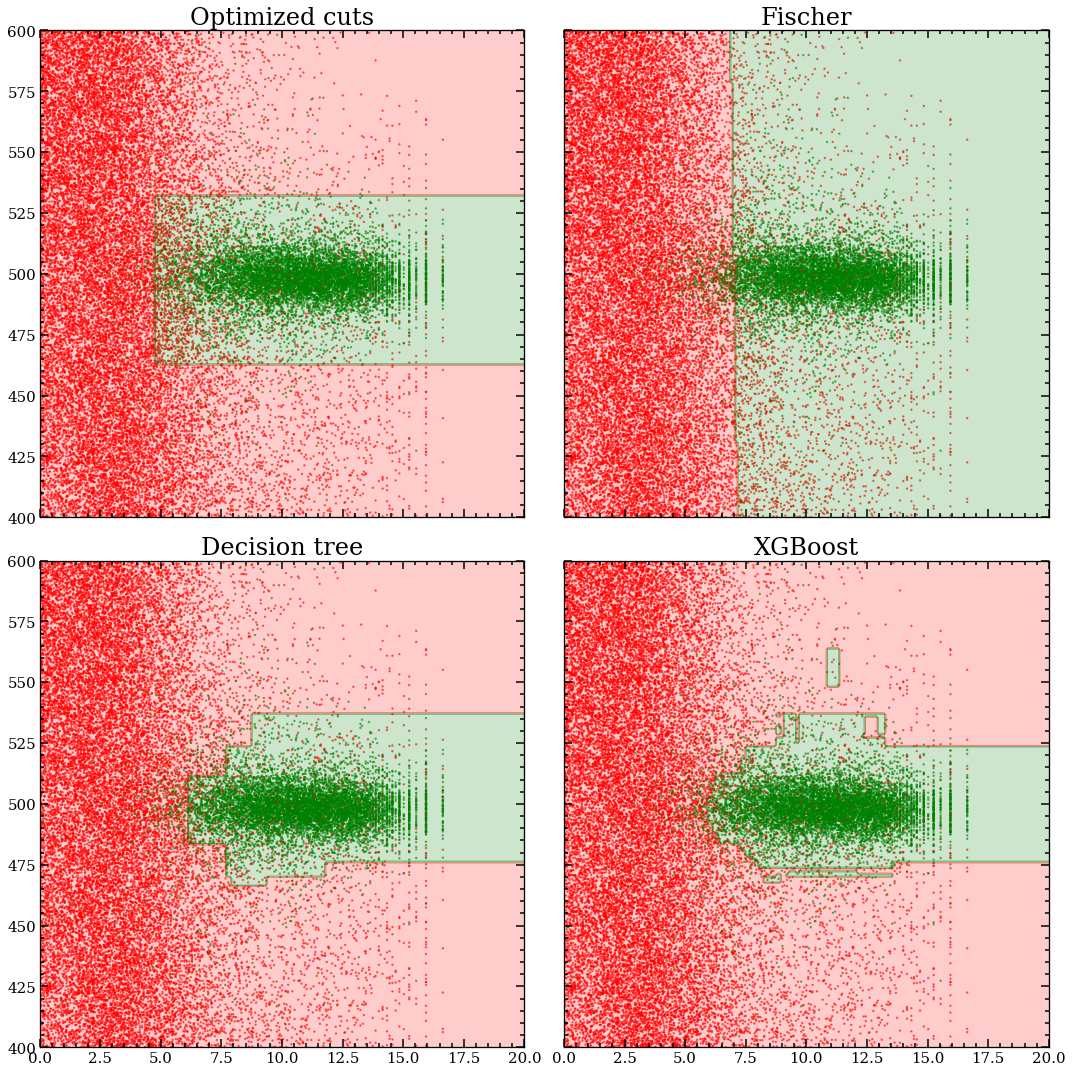

In [339]:
fig, ax = plt.subplots(figsize = (15,15),ncols=2,nrows=2,sharex=True,sharey=True)
ax = ax.flatten()
N_plot = int(1e5)
titles = ['Optimized cuts','Fischer','Decision tree','XGBoost']
for i, axes in enumerate(ax):
    axes.scatter(test_mc.cosTheta[:N_plot],test_mc.v0_ks_mass[:N_plot],s=2,c=test_mc.trueKs[:N_plot],cmap=matplotlib.colors.ListedColormap(['red','green']),alpha=0.5)
    axes.set(xlim=(0,20),ylim=(400,600))
    axes.set_title(titles[i],fontsize=24)
#     axes.set(xlim=(-400,-300),ylim=(300,400))
    
grid_class(cla_cuts,ax[0])
# grid_class(cla_lda,ax[1])
grid_class(cla_fisher,ax[1])
grid_class(cla_dt,ax[2])
grid_class(cla_xgb,ax[3])

fig.tight_layout()

In [340]:
# fig.savefig('figures/decision_boundaries.png')
# fig.savefig('correlated_decision_boundaries.png')